In [2]:

%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import pandas as pd

train = np.loadtxt('../data/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../data/test.csv', delimiter=',', skiprows=1)

In [3]:

train_label = train[:, 0]
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

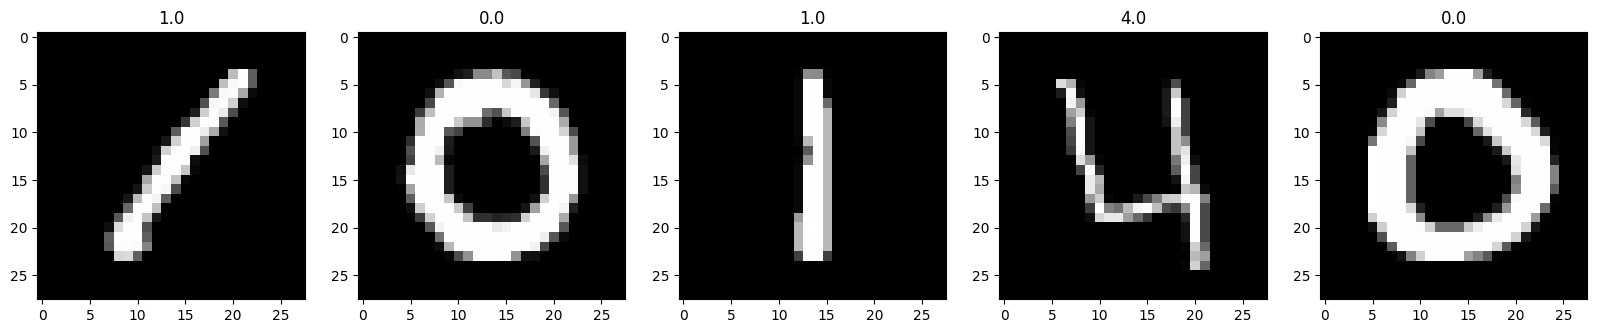

In [4]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('%s' % train_label[i - 1])

In [5]:
def extract_hog_features(images):
    features = []
    for img in images:

        hog_features = hog(img,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          block_norm='L2-Hys')
        features.append(hog_features)
    return np.array(features)

print("Извлечение HOG-признаков...")
train_hog = extract_hog_features(train_img)
test_hog = extract_hog_features(test_img)

Извлечение HOG-признаков...


In [6]:
scaler = StandardScaler()
train_hog_scaled = scaler.fit_transform(train_hog)
test_hog_scaled = scaler.transform(test_hog)


y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hog_scaled, test_size=0.2, random_state=42)

Обучение SVM...
Оценка качества...
Accuracy: 0.9704761904761905
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       816
         1.0       0.99      0.99      0.99       909
         2.0       0.97      0.98      0.97       846
         3.0       0.98      0.95      0.96       937
         4.0       0.98      0.97      0.97       839
         5.0       0.97      0.96      0.97       702
         6.0       0.98      0.99      0.98       785
         7.0       0.97      0.96      0.96       893
         8.0       0.94      0.96      0.95       835
         9.0       0.95      0.96      0.96       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400

[[799   2   2   2   0   1   5   2   3   0]
 [  0 903   1   0   2   0   1   1   1   0]
 [  0   2 826   3   1   2   0   4   8   0]
 [  0   0   9 891   0   5   0   6  21   5]
 [  0

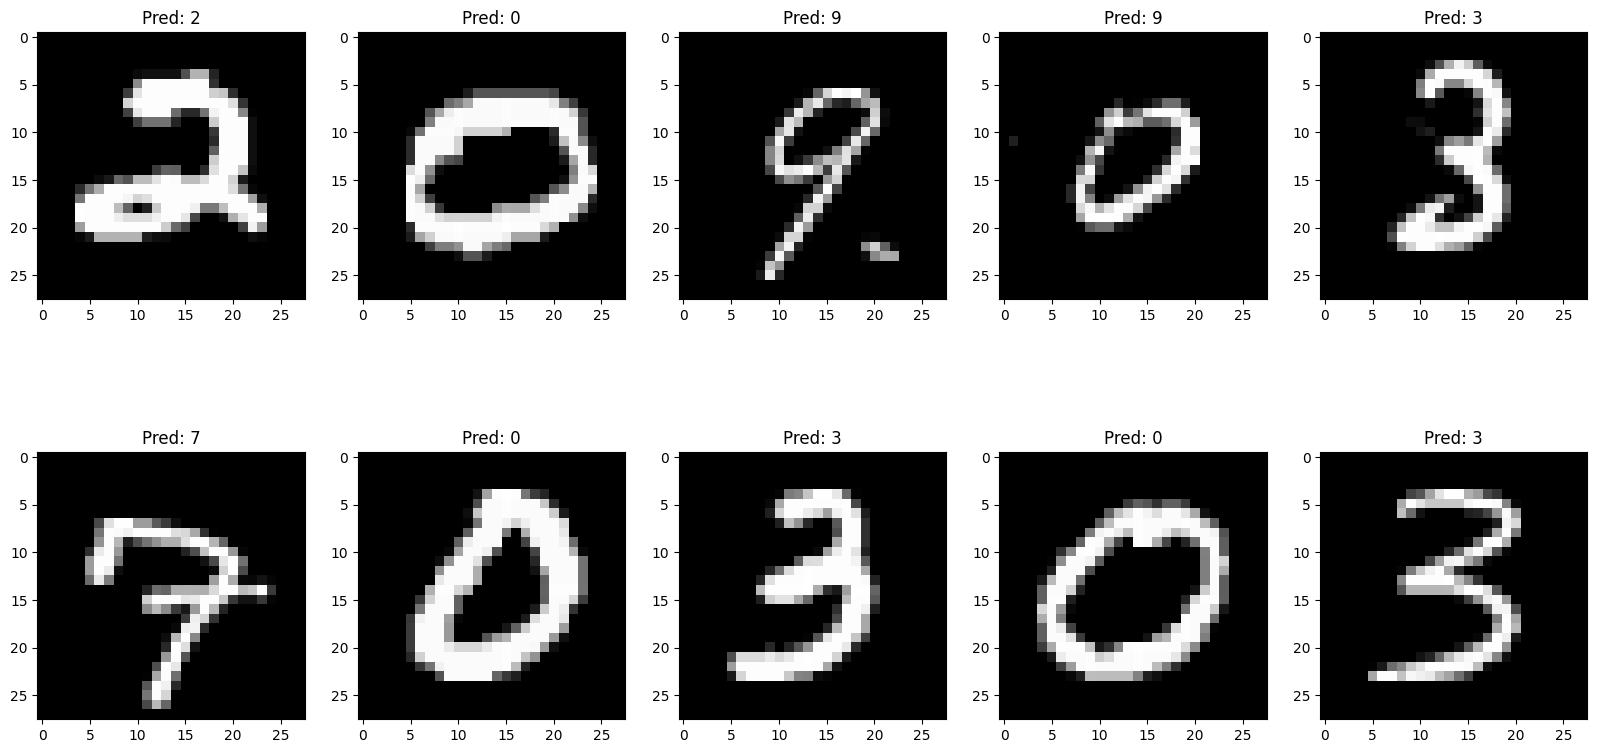

In [7]:
print("Обучение SVM...")
svm_classifier = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42
)
svm_classifier.fit(x_train, y_train)

print("Оценка качества...")
pred_val = svm_classifier.predict(x_val)

print('Accuracy: %s' % accuracy_score(y_val, pred_val))
print(classification_report(y_val, pred_val))
print(confusion_matrix(y_val, pred_val))

pred_test = svm_classifier.predict(test_hog_scaled)
pred_test = pred_test.astype(int)

fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('Pred: %s' % int(pred_test[i - 1]))

submit_df = pd.DataFrame({
    'ImageId': range(1, len(pred_test) + 1),
    'Label': pred_test
})
submit_df.to_csv('svm_submission.csv', index=False)

print("Файл для отправки сохранен как 'svm_submission.csv'")
print("Первые 5 строк файла:")
print(submit_df.head())